# Test Linear Lifting via Synthetic LDS
The goal here is to verify that we are able to learn linearizing maps. As such, we play around below in the situation where there is an underlying LDS with some nonlinear observations. We are interested in checking whether we are able to reproduce the underlying LDS.

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS, Gym
from extravaganza.sysid import Lifter
from extravaganza.utils import summarize_lds, sample, jkey, opnorm

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = None
SYSID_SEED = None

INFO: Created a temporary directory at /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpfpk2v1m1
INFO: Writing /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpfpk2v1m1/_remote_module_non_scriptable.py


In [39]:
def obs_func(x):
    return jnp.sign(x) * (jnp.abs(x) ** 0.5)   # looks sorta sigmoidal
#     return x

# make g.t. linear system
du = 6  # control dim
ds = 16  # state dim
system = LDS(ds, du, 'none', 'quad', seed=SYSTEM_SEED)
A, B = system.A, system.B
print(summarize_lds(A, B))

# make sysid
T0 = 10000
reset_every = 50
dl = 16

sysid_args = {
    'obs_dim': ds,
    'control_dim': du,

    'max_traj_len': int(1e6),
    'exploration_scales': 1.,

    'AB_method': 'learned',
    
    'sigma': 0.,
    'determinstic_encoder': True,
    'depth': 6,
    'num_epochs': 6000,
    'lifter_lr': 0.0004,

    'seed': SYSID_SEED,
}
sysid = Lifter(method='nn', state_dim=dl, **sysid_args)

# interaction loop
states = []
control = jnp.zeros(du)
for t in tqdm.trange(T0):
    if t % reset_every == 0: 
        system.reset()
        system.state = sample(jkey(), (ds,), sampling_method='sphere')
        sysid.end_trajectory()
    cost, state = system.interact(control)
    states.append(state)
    obs = obs_func(state)
    control = sysid.explore(cost, obs)
Ahat, Bhat = sysid.end_exploration(wordy=True)

INFO: (LDS) for the LDS we are !!!NOT!!! reporting the costs with the `u.T @ R @ u` part
INFO: (LDS): initial state is [-1.898508   -1.0064001   2.0777147  -0.43123963 -1.4051675  -0.9905854
 -0.31232417 -0.17178749  0.33622125  0.3031092  -1.0623996  -1.5532845
  0.63023114 -0.744705   -0.00429837 -0.10062545]
INFO: (PC3): decoder not provided, so reconstruction error will NOT be computed
INFO: (PC3): contrastive predictive coding will NOT be computed
INFO: (PC3): jacobian loss will NOT be computed
INFO: (PC3): using "learned" method to get the AB matrices during each training step


||A||_op = 0.9305210709571838
||B||_F = 7.885181903839111
||A-BK||_op = 0.6604080200195312


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 945.45it/s]
INFO: (LIFTER): ending sysid phase at step 10000
INFO: training!
INFO: mean loss for epochs -600 - 0:
INFO: 		l2 linearization: 0.6170406937599182
INFO: 		simplification: 0.0869951918721199
INFO: mean loss for epochs 0 - 600:
INFO: 		l2 linearization: 0.34167826975385346
INFO: 		simplification: 0.01284198758813242
INFO: mean loss for epochs 600 - 1200:
INFO: 		l2 linearization: 0.1902100167175134
INFO: 		simplification: 0.008972313201908643
INFO: mean loss for epochs 1200 - 1800:
INFO: 		l2 linearization: 0.08952507302785913
INFO: 		simplification: 0.0059099401273609445
INFO: mean loss for epochs 1800 - 2400:
INFO: 		l2 linearization: 0.040975602719311915
INFO: 		simplification: 0.0034581280945955467
INFO: mean loss for epochs 2400 - 3000:
INFO: 		l2 linearization: 0.018155103439154725
INFO: 		simplification: 0.001988543940630431
INFO: me

tensor(45.0275)
||A||_op = 2.862597703933716
||B||_F = 13.663047790527344
||A-BK||_op = 0.9568167328834534


In [ ]:
from extravaganza.utils import summarize_lds; import torch
print(summarize_lds(sysid.lifter.A.detach().data.numpy(), sysid.lifter.B.detach().data.numpy()))
print()
print(summarize_lds(Ahat, Bhat))

In [36]:
# check how well we do at prediction
x = sample(jkey(), (ds,), sampling_method='ball')
# x = states[np.random.randint(len(states))]
s = sysid.get_state(obs_func(x))
original = s.copy()
for _ in range(1):
    u = sample(jkey(), (du,), sampling_method='normal')
    x = A @ x + B @ u
    s = Ahat @ s + Bhat @ u 
gt = sysid.get_state(obs_func(x))
pred = s.copy()
print(jnp.linalg.norm(gt - original), jnp.linalg.norm(pred - original), jnp.linalg.norm(gt - pred))
print('original:', original)
print('gt:', gt)
print('pred:', pred)

3.7701344 4.6723504 0.90427345
original: [-0.40065452  0.16128615 -0.38660365 -0.1906097  -0.0339026  -0.43510616
 -0.9707034   0.06679669  0.2731599   0.3561817   1.0116923   0.30082297
 -0.47164476 -0.04406445 -0.11864424 -0.55146813]
gt: [-1.4104177  -0.98610014 -0.65124583  0.74938446 -0.01615215  0.84727496
 -1.4927555  -1.2476437  -1.5455992   0.13033676  0.22925034  0.4452033
 -0.82051516 -1.0104893   1.3549812  -0.30681986]
pred: [-1.6408315  -1.2839931  -0.72355884  0.9633069  -0.01569783  1.177322
 -1.5810227  -1.5668228  -1.9904276   0.05202991  0.05400772  0.49921256
 -0.89438766 -1.2283422   1.6894679  -0.24468721]


||A - C @ Ahat @ C.T||^2 / ||A||^2: 	2006464593920.00%
||B - C @ Bhat||^2 / ||B||^2: 		65.73%
Avg % Err (residual norm ** 2 / state norm ** 2): 	63.62%


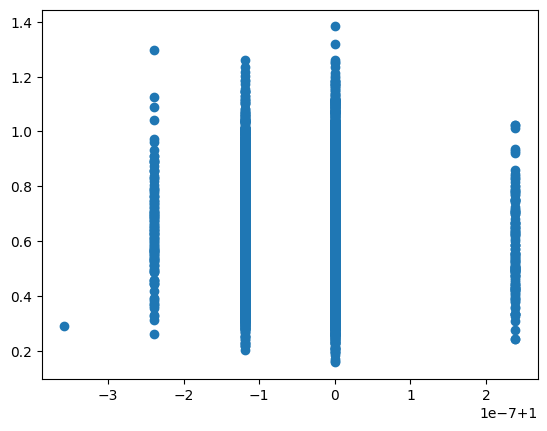

In [38]:
# We know that if we have succeeded, our embedding composed with our observation function is a linear transformation of the original state.
# Below, we regress this transformation, C, and compute some errors with it.

rand_states = sample(jkey(), (10000, ds), sampling_method='sphere')
# rand_states = jnp.stack(states, axis=0)

emb = jnp.stack([sysid.get_state(obs_func(r)) for r in rand_states], axis=0)

C = jnp.linalg.lstsq(emb, rand_states, rcond=-1)[0].T

print('||A - C @ Ahat @ C.T||^2 / ||A||^2: \t{:.2f}%'.format(100 * jnp.linalg.norm(A - C @ Ahat @ C.T) ** 2 / jnp.linalg.norm(A) ** 2))
print('||B - C @ Bhat||^2 / ||B||^2: \t\t{:.2f}%'.format(100 * jnp.linalg.norm(B - C @ Bhat) ** 2 / jnp.linalg.norm(B) ** 2))

residuals = (C[None] @ emb[:, :, None]).squeeze() - rand_states
residual_norms = jnp.linalg.norm(residuals, axis=-1) ** 2
state_norms = jnp.linalg.norm(rand_states, axis=-1) ** 2

print('Avg % Err (residual norm ** 2 / state norm ** 2): \t{:.2f}%'.format(100 * jnp.mean(residual_norms / state_norms)))
plt.scatter(state_norms, residual_norms / state_norms)

## Test on Pendulum
So, we see that we can recreate a synthetic LDS. However, I am not convinced until I see that we are able to reproduce harder systems, such as the pendulum. 

In [ ]:
# make pendulum
system = Gym('Pendulum-v1', repeat=2, render=False, seed=SYSTEM_SEED)
ds = system.state_dim
du = system.control_dim

# make sysid
T0 = 5000
reset_every = 200
dl = 4

sysid_args = {
    'obs_dim': ds,
    'control_dim': du,

    'max_traj_len': int(1e6),
    'exploration_scales': 4.,

    'sigma': 0.,
    'determinstic_encoder': True,
    'depth': 3,
    'num_epochs': 5000,
    'lifter_lr': 0.001,

    'seed': SYSID_SEED,
}
sysid = Lifter(method='nn', state_dim=dl, **sysid_args)

# interaction loop
control = jnp.zeros(du)
for t in tqdm.trange(T0):
    if t % reset_every == 0: 
        system.reset()
        system.state = sample(jkey(), (ds,), sampling_method='ball')
    cost, state = system.interact(control)
    control = sysid.explore(cost, state)
Ahat, Bhat = sysid.end_exploration(wordy=True)

In [ ]:
# check how well we do at prediction
system.reset()
x = system.state.astype(np.float32)
s = sysid.get_state(x)
original = s.copy()
for _ in range(1):
    u = sample(jkey(), (du,), sampling_method='normal')
    f, x = system.interact(u)
    s = Ahat @ s + Bhat @ u
gt = sysid.get_state(x)
pred = s.copy()
print(jnp.linalg.norm(gt - original), jnp.linalg.norm(pred - original), jnp.linalg.norm(gt - pred))
print('x:', x)
print('cost:', f)
print('original:', original)
print('gt:', gt)
print('pred:', pred)